In [64]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [65]:
# All the config variables/flags go here
# Which dataset to use
dataset = "offset_T1.csv"
path = os.path.join(os.getcwd(), "test_datasets", dataset)

# Random seed, leave as is for consistency
tf.random.set_seed(1234)

# Window size (inputs)
window = 30

# Model layer units
units = 64

# Read in data
raw_data = pd.read_csv(path, parse_dates=["date"])

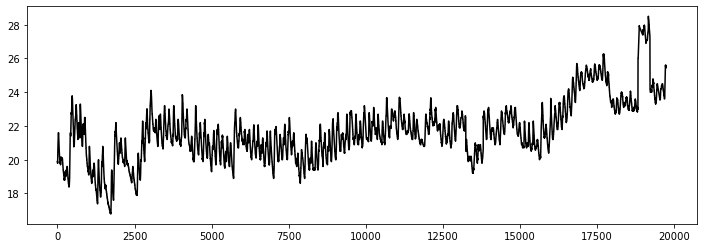

In [66]:
plt.figure(figsize=(12, 4))
plt.plot(raw_data.index, raw_data["T1"], color="black")

In [67]:
train_size = int(len(raw_data) * 0.6)
temp_values = raw_data["T1"]
train_data = temp_values[:train_size].to_numpy().reshape(-1, 1)
test_data = temp_values[train_size:].to_numpy().reshape(-1, 1)

In [68]:
scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [69]:
def create_dataset(x, look_back=1):
    xs, ys = [], []

    for i in range(len(x) - look_back):
        v = x[i:i + look_back]
        xs.append(v)
        ys.append(x[i + look_back])

    return np.array(xs), np.array(ys)

x_train, y_train = create_dataset(train_scaled, window)
x_test, y_test = create_dataset(test_scaled, window)

In [70]:
# Create the model
model = Sequential()

# Input layer
model.add(GRU(units=units, return_sequences=True,
              input_shape=[x_train.shape[1], x_train.shape[2]]))
model.add(Dropout(0.2))

# Hidden layer
model.add(GRU(units=units))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

model.compile(optimizer="adam",loss="mse")

In [71]:
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss",
                                           patience=10)
history = model.fit(x_train, y_train, epochs=100,
                    validation_split=0.2,
                    batch_size=16, shuffle=False,
                    callbacks=[early_stop])

y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

Epoch 1/100
591/591 [==============================] - 12s 15ms/step - loss: 0.0057 - val_loss: 8.2960e-04
Epoch 2/100
591/591 [==============================] - 9s 15ms/step - loss: 0.0019 - val_loss: 4.0167e-04
Epoch 3/100
591/591 [==============================] - 9s 15ms/step - loss: 0.0016 - val_loss: 5.6057e-04
Epoch 4/100
591/591 [==============================] - 9s 16ms/step - loss: 0.0012 - val_loss: 1.5350e-04
Epoch 5/100
591/591 [==============================] - 9s 16ms/step - loss: 9.8431e-04 - val_loss: 3.5584e-04
Epoch 6/100
591/591 [==============================] - 9s 16ms/step - loss: 8.1503e-04 - val_loss: 9.2457e-05
Epoch 7/100
591/591 [==============================] - 9s 15ms/step - loss: 6.6158e-04 - val_loss: 4.4363e-05
Epoch 8/100
591/591 [==============================] - 9s 15ms/step - loss: 6.0432e-04 - val_loss: 5.6163e-05
Epoch 9/100
591/591 [==============================] - 9s 15ms/step - loss: 5.4859e-04 - val_loss: 1.3344e-04
Epoch 10/100
591/591 [===

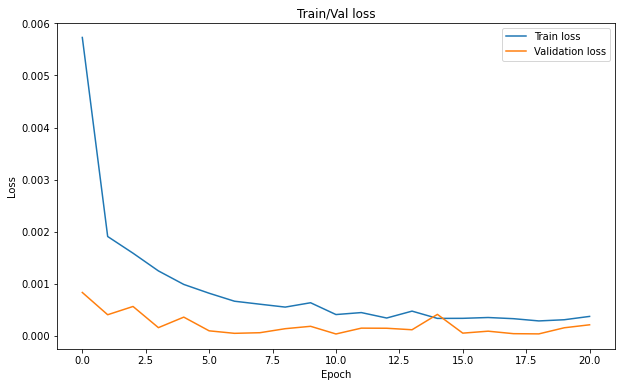

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Train/Val loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train loss", "Validation loss"], loc="upper right")

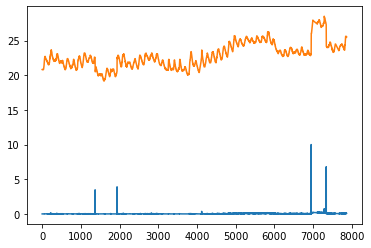

In [73]:
prediction = model.predict(x_test)
prediction = scaler.inverse_transform(prediction)

errors = prediction - y_test
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()

mse_all = prediction - y_test
mse_all = np.square(mse_all)
plt.plot(mse_all)
plt.plot(y_test)
plt.show()

In [74]:
median_mse = np.median(mse_all)
stdev_mse = np.std(mse_all)

threshold = median_mse + stdev_mse
for x in range(0, 10):
    threshold = median_mse + stdev_mse * x / 10

    predicted_anomalies = mse_all > threshold

    generated_anomalies = raw_data["T1_class"][train_size + 30:].to_numpy().reshape(-1, 1)
    print("=== Statistics for threshold {} ===".format(threshold))
    print(confusion_matrix(generated_anomalies, predicted_anomalies))

=== Statistics for threshold 0.019887594150711334 ===
[[3378 3530]
 [ 554  402]]
=== Statistics for threshold 0.03538120308624851 ===
[[4627 2281]
 [ 563  393]]
=== Statistics for threshold 0.05087481202178569 ===
[[5389 1519]
 [ 565  391]]
=== Statistics for threshold 0.06636842095732287 ===
[[5903 1005]
 [ 570  386]]
=== Statistics for threshold 0.08186202989286004 ===
[[6358  550]
 [ 572  384]]
=== Statistics for threshold 0.09735563882839723 ===
[[6673  235]
 [ 576  380]]
=== Statistics for threshold 0.1128492477639344 ===
[[6777  131]
 [ 583  373]]
=== Statistics for threshold 0.1283428566994716 ===
[[6853   55]
 [ 589  367]]
=== Statistics for threshold 0.14383646563500876 ===
[[6884   24]
 [ 600  356]]
=== Statistics for threshold 0.15933007457054593 ===
[[6894   14]
 [ 629  327]]
